# Лабораторная работа 4.1 Построение и оценка модели для прогнозирования оттока клиентов

**Тема.** Интерпретация результатов модели для принятия бизнес-решений

**Курс.** Python для анализа данных

**Специальность.** Бизнес-информатика

### Цель работы:
Научиться применять модели машинного обучения (регрессию и классификацию) для решения реальных бизнес-задач, а также интерпретировать полученные результаты для формирования практических рекомендаций и принятия управленческих решений.

---

## Машинное обучение как инструмент бизнес-аналитика

В современном бизнесе данные — это стратегический актив. Способность предсказывать будущее поведение клиентов, оценивать риски и оптимизировать процессы напрямую влияет на прибыльность компании. Машинное обучение (ML) предоставляет для этого мощный инструментарий.

**Сквозной бизнес-кейс.** На протяжении всей этой работы мы будем решать одну из самых классических и важных задач — **прогнозирование оттока клиентов (Customer Churn)** на примере телеком-оператора.

**Почему это важно для бизнеса?**
- **Прямые финансовые потери.** Потерянный клиент — это потерянный доход.
- **Высокая стоимость привлечения.** Привлечь нового клиента в 5-7 раз дороже, чем удержать существующего.

Наша цель — не просто построить модель, которая предсказывает отток, а понять, **как использовать её результаты для реальных действий**: кому из клиентов предложить скидку, на какие факторы обратить внимание, чтобы снизить отток в будущем.

## Часть 1. Подготовка к анализу

Импортируем необходимые библиотеки и загрузим наш датасет.

In [1]:
# Установка библиотек (если требуется)
!pip install pandas numpy matplotlib seaborn scikit-learn -q

# Импорт основных библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Импорт инструментов для предобработки данных
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Импорт моделей
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier

# Импорт метрик для оценки
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error, r2_score

# Настройки для визуализаций
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)

**Задание 1: Загрузка и первичный осмотр данных**

Загрузите датасет по оттоку клиентов телеком-оператора по предоставленной ссылке. Выведите первые 5 строк (`.head()`) и общую информацию о данных (`.info()`).

In [2]:
# URL датасета
url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'

# Ваш код здесь
# 1. Загрузите данные в DataFrame 'df'
df = pd.read_csv(url)

# 2. Выведите первые 5 строк
display(df.head())

# 3. Выведите информацию о DataFrame
df.info()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## Часть 2. Исследовательский анализ данных (EDA) для бизнес-гипотез

Цель EDA — не просто посмотреть на данные, а найти в них инсайты, которые помогут нам в дальнейшем моделировании и принятии решений.

**Задание 2. Анализ целевой переменной**

Наша целевая переменная для задачи классификации — столбец `Churn` (Отток). Постройте столбчатую диаграмму (`countplot` из seaborn), чтобы визуализировать распределение классов. Сделайте вывод о сбалансированности классов.

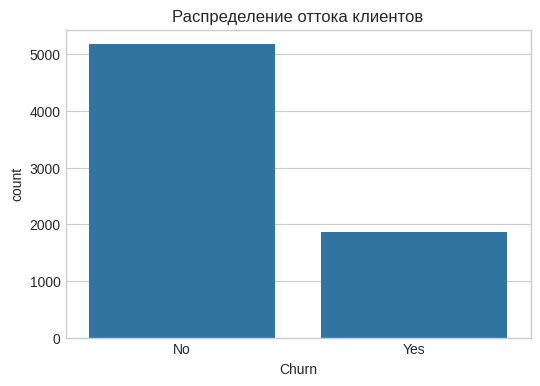

In [3]:
# Ваш код здесь
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Churn')
plt.title('Распределение оттока клиентов')
plt.show()

# Вывод: классы несбалансированы, лояльных клиентов значительно больше, чем ушедших.
# Это нужно будет учитывать при оценке модели.

**Задание 3: Влияние типа контракта на отток**

**Бизнес-гипотеза.** Клиенты с краткосрочными контрактами (Month-to-month) более склонны к оттоку.
Проверьте эту гипотезу, построив `countplot` для столбца `Contract`, разделив его по значениям `Churn` (используйте параметр `hue`).

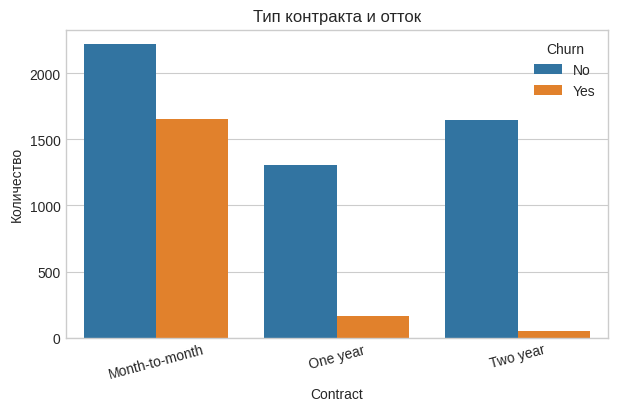

In [4]:
# Ваш код здесь
plt.figure(figsize=(7,4))
sns.countplot(data=df, x='Contract', hue='Churn', hue_order=['No','Yes'])
plt.title('Тип контракта и отток')
plt.xlabel('Contract'); plt.ylabel('Количество')
plt.xticks(rotation=15)
plt.legend(title='Churn')
plt.show()

**Задание 4. Влияние ежемесячных платежей на отток**

**Бизнес-гипотеза.** Клиенты с более высокими ежемесячными платежами чаще уходят.
Проверьте это, построив `boxplot` (ящик с усами), где по оси X будет `Churn`, а по оси Y — `MonthlyCharges`.

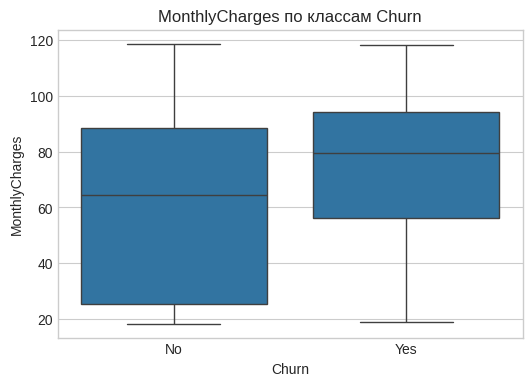

In [5]:
# Ваш код здесь
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='Churn', y='MonthlyCharges', order=['No','Yes'])
plt.title('MonthlyCharges по классам Churn')
plt.xlabel('Churn'); plt.ylabel('MonthlyCharges')
plt.show()

## Часть 3. Подготовка данных для моделирования (Pre-processing)

Модели машинного обучения работают с числами. Нам нужно преобразовать наши данные: категориальные признаки — в числовые, а числовые — отмасштабировать.

**Задание 5. Предобработка данных**

Выполните следующие шаги:
1. `TotalCharges` имеет тип `object`. Преобразуйте его в числовой с помощью `pd.to_numeric`, а ошибки замените на `NaN` (`errors='coerce'`).
2. Заполните пропуски в `TotalCharges` медианным значением.
3. Целевую переменную `Churn` преобразуйте в 0 и 1.
4. Удалите ненужный для моделирования столбец `customerID`.

In [6]:
# Ваш код здесь
# 1. Преобразование TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 2. Заполнение пропусков
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# 3. Преобразование Churn
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1}).astype(int)

# 4. Удаление customerID
df = df.drop(columns=['customerID'])

df.info() # Проверка, что все типы данных корректны

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


**Задание 6. Разделение признаков и создание пайплайна**

1. Определите `X` (все столбцы, кроме `Churn`) и `y` (`Churn`).
2. Разделите `X` и `y` на обучающую и тестовую выборки (`train_test_split`) в соотношении 80/20.
3. Определите списки числовых (`numerical_features`) и категориальных (`categorical_features`) признаков.
4. Создайте пайплайн предобработки `preprocessor` с помощью `ColumnTransformer`, который будет масштабировать числовые признаки (`StandardScaler`) и кодировать категориальные (`OneHotEncoder`).

In [7]:
# Ваш код здесь
# 1. Определение X и y
X = df.drop(columns=['Churn'])
y = df['Churn']

# 2. Разделение на train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Определение типов признаков
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# 4. Создание ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

print("Пайплайн предобработки успешно создан.")

Пайплайн предобработки успешно создан.


## Часть 4. Задача классификации - Прогнозирование оттока

**Задание 7. Обучение модели логистической регрессии**

Создайте пайплайн `log_reg_pipeline`, который последовательно будет выполнять шаги `preprocessor` и обучать модель `LogisticRegression`. Обучите этот пайплайн на `X_train`, `y_train`.

In [8]:
# Ваш код здесь
log_reg_pipeline = Pipeline(steps=[
    ('prep', preprocessor),
    ('model', LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42))
])

log_reg_pipeline.fit(X_train, y_train)
print('Модель обучена.')

Модель обучена.


**Задание 8. Оценка модели и интерпретация для бизнеса**

1. Сделайте предсказания на тестовой выборке (`X_test`).
2. Рассчитайте `accuracy`.
3. Постройте **матрицу ошибок (confusion matrix)** и проинтерпретируйте её с точки зрения бизнеса.

Точность (Accuracy): 0.74


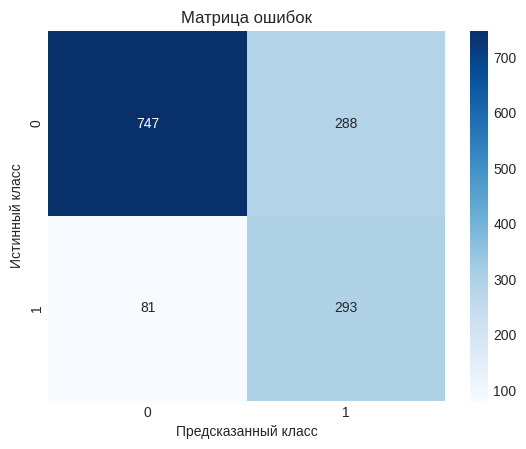

In [9]:
# Ваш код здесь
# 1. Предсказания
y_pred = log_reg_pipeline.predict(X_test)

# 2. Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность (Accuracy): {accuracy:.2f}")

# 3. Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()

# Интерпретация для бизнеса:
# True Negative (TN, левый верхний угол). Мы правильно определили лояльных клиентов. Это хорошо.
# False Positive (FP, правый верхний угол). Мы ошибочно предсказали отток лояльному клиенту. Бизнес-риск: мы можем потратить деньги на удержание клиента, который и так бы не ушел.
# False Negative (FN, левый нижний угол). Мы не смогли предсказать отток, и клиент ушел. Это самая большая проблема! Мы упустили возможность его удержать и потеряли доход.
# True Positive (TP, правый нижний угол). Мы правильно предсказали отток. Это позволяет нам вовремя принять меры.

<details>
<summary>Нажмите, чтобы увидеть решение</summary>

```python
y_pred = log_reg_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность (Accuracy): {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()
```

</details>

**Задание 9. Анализ важности признаков**

Для линейных моделей, таких как логистическая регрессия, мы можем посмотреть на коэффициенты, чтобы понять, какие признаки наиболее сильно влияют на отток. Извлеките коэффициенты и названия признаков из пайплайна и создайте DataFrame для их анализа.

In [10]:
# Ваш код здесь
prep = log_reg_pipeline.named_steps['prep']
ohe  = prep.named_transformers_['cat']

cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = np.r_[numerical_features, cat_names]

coef = log_reg_pipeline.named_steps['model'].coef_.ravel()
coef_df = pd.DataFrame({'feature': feature_names, 'coef': coef})
coef_df = coef_df.assign(abs_coef=lambda d: d['coef'].abs()) \
                 .sort_values('abs_coef', ascending=False)

display(coef_df[['feature','coef']].head(10))

,feature,coef
1,tenure,-1.123595
38,Contract_Two year,-0.781255
16,InternetService_Fiber optic,0.705337
2,MonthlyCharges,-0.663583
36,Contract_Month-to-month,0.663399
15,InternetService_DSL,-0.621009
3,TotalCharges,0.457218
35,StreamingMovies_Yes,0.274978
25,DeviceProtection_No internet service,-0.274569
17,InternetService_No,-0.274569


<details>
<summary>Нажмите, чтобы увидеть решение</summary>

```python
try:
    # Получаем названия закодированных признаков из препроцессора
    feature_names = log_reg_pipeline.named_steps['preprocessor'].get_feature_names_out()
    
    # Получаем коэффициенты из классификатора
    # ИСПРАВЛЕНИЕ: Добавляем [0], так как coef_ возвращает массив вида [[...]], а нам нужен плоский список
    coefficients = log_reg_pipeline.named_steps['classifier'].coef_[0]

    # Создаем DataFrame
    coef_df = pd.DataFrame({'Признак': feature_names, 'Коэффициент': coefficients})
    
    # Рассчитываем абсолютное значение влияния
    coef_df['Влияние'] = np.abs(coef_df['Коэффициент'])
    
    # Сортируем по силе влияния
    coef_df = coef_df.sort_values(by='Влияние', ascending=False)

    print("Топ-10 признаков, влияющих на отток:")
    display(coef_df.head(10))
    
    # Бизнес-интерпретация:
    # Положительные коэффициенты (ближе к верху списка, если они положительные) увеличивают вероятность оттока.
    # Отрицательные коэффициенты уменьшают вероятность оттока (удерживают клиента).
    
except Exception as e:
    print(f"Ошибка при извлечении признаков: {e}")
```

</details>

## Часть 5. Задача регрессии - Прогнозирование ценности клиента (LTV)

Не все клиенты одинаково ценны. Прогнозирование **LTV (Lifetime Value)**, или в нашем случае, `TotalCharges` (общие расходы клиента), поможет понять, на удержание каких клиентов стоит тратить больше усилий.

**Задание 10. Подготовка данных для регрессии**

Целевая переменная теперь — `TotalCharges`.
1. Создайте `X_reg` (все столбцы, кроме `TotalCharges` и `customerID`, `Churn`) и `y_reg` (`TotalCharges`).
2. Разделите данные на обучающую и тестовую выборки.

In [11]:
# Загрузим и очистим данные заново для чистоты эксперимента
df_reg = pd.read_csv(url)
df_reg['TotalCharges'] = pd.to_numeric(df_reg['TotalCharges'], errors='coerce')
df_reg.dropna(inplace=True)

# Ваш код здесь
# 1. Определение X и y
X_reg = df_reg.drop(columns=['TotalCharges', 'customerID', 'Churn'])
y_reg = df_reg['TotalCharges'].astype(float)

# 2. Разделение на train/test
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print("Данные для регрессии подготовлены.")

Данные для регрессии подготовлены.


**Задание 11. Обучение модели линейной регрессии**

Создайте пайплайн для линейной регрессии, который включает `preprocessor` (тот же, что и раньше, но адаптированный под новые `X`) и модель `LinearRegression`. Обучите его.

In [12]:
numerical_features_reg   = X_train_reg.select_dtypes(include='number').columns.tolist()
categorical_features_reg = X_train_reg.select_dtypes(exclude='number').columns.tolist()

preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_reg),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_reg)
    ]
)

linreg_pipeline = Pipeline([
    ('prep', preprocessor_reg),
    ('model', LinearRegression())
])

linreg_pipeline.fit(X_train_reg, y_train_reg)
print('Линейная регрессия обучена.')

Линейная регрессия обучена.


**Задание 12. Оценка и интерпретация модели регрессии**

1. Сделайте предсказания на `X_test_reg`.
2. Рассчитайте метрики **RMSE** и **R² (R-squared)**.
3. Визуализируйте результат: постройте диаграмму рассеяния (`scatterplot`), где по одной оси будут реальные значения, а по другой — предсказанные.

RMSE: 673.95
R-squared: 0.91


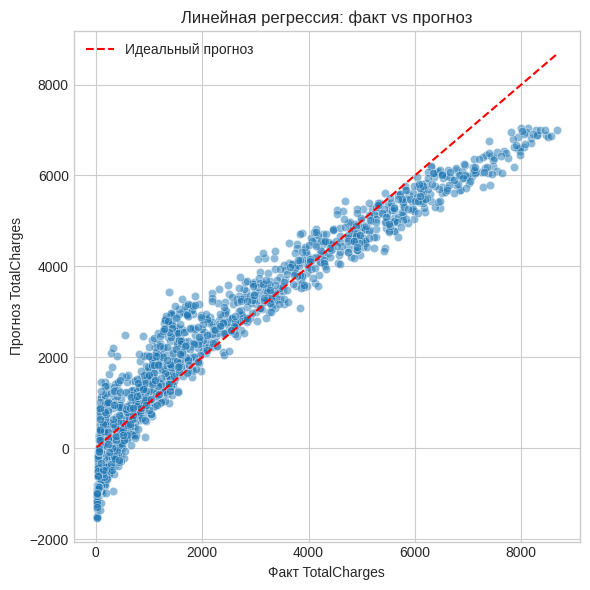

In [13]:
# Ваш код здесь
# 1. Предсказания
y_pred_reg = linreg_pipeline.predict(X_test_reg)

# 2. Метрики
mse_reg = mean_squared_error(y_test_reg, y_pred_reg)
rmse_reg = mse_reg ** 0.5
r2_reg   = r2_score(y_test_reg, y_pred_reg)


print(f"RMSE: {rmse_reg:.2f}")
print(f"R-squared: {r2_reg:.2f}")

# 3. Визуализация
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test_reg, y=y_pred_reg, alpha=0.5)
mn, mx = y_test_reg.min(), y_test_reg.max()
plt.plot([mn, mx], [mn, mx], 'r--', label='Идеальный прогноз')
plt.xlabel('Факт TotalCharges'); plt.ylabel('Прогноз TotalCharges')
plt.title('Линейная регрессия: факт vs прогноз')
plt.legend(); plt.tight_layout(); plt.show()
# Бизнес-интерпретация:
# RMSE показывает среднюю ошибку прогноза в долларах. R² показывает, какую долю дисперсии целевой переменной объясняет наша модель.
# На графике идеальный прогноз лежал бы на диагональной линии. Мы видим, что модель в целом улавливает тренд, но имеет заметную ошибку.

## Часть 6. Комплексное бизнес-решение

Теперь объединим результаты обеих моделей для принятия взвешенного решения.

**Задание 13. Создание финального DataFrame с прогнозами**

Сделайте предсказания обеими моделями на всем датасете и добавьте их как новые столбцы: `churn_probability` (вероятность оттока) и `predicted_ltv`.

In [14]:
# Ваш код здесь
features_clf = list(numerical_features) + list(categorical_features)
X_full_clf = df[features_clf]
churn_prob = log_reg_pipeline.predict_proba(X_full_clf)[:, 1]

features_reg = list(numerical_features_reg) + list(categorical_features_reg)
X_full_reg = df[features_reg]
pred_ltv = linreg_pipeline.predict(X_full_reg)

df_final = df[['Churn', 'TotalCharges']].copy()
df_final['churn_probability'] = churn_prob
df_final['predicted_ltv']     = pred_ltv

display(df_final.head(), df_final.shape)

,Churn,TotalCharges,churn_probability,predicted_ltv
0,0,29.85,0.802138,-1029.111908
1,0,1889.50,0.118952,2241.371627
2,1,108.15,0.531901,278.429079
3,0,1840.75,0.081651,2491.085068
4,1,151.65,0.854034,63.498266


(7043, 4)

**Задание 14. Сегментация клиентов для принятия решений**

**Бизнес-задача.** Нам нужно выделить сегмент клиентов, на удержание которых стоит потратить ресурсы в первую очередь.
**Критерии.**
1. Высокая вероятность оттока (`churn_probability > 0.6`).
2. Высокая прогнозируемая ценность (`predicted_ltv` выше 75-го перцентиля).

Отфильтруйте `df_final` по этим двум критериям и выведите результат.

In [15]:
# Ваш код здесь
p75 = df_final['predicted_ltv'].quantile(0.75)

priority_segment = (df_final
    .loc[(df_final['churn_probability'] > 0.6) & (df_final['predicted_ltv'] > p75)]
    .sort_values(['churn_probability','predicted_ltv'], ascending=False))

print(f'Порог 75-го перцентиля predicted_ltv: {p75:.2f}')
print('Размер сегмента:', len(priority_segment))
display(priority_segment.head(20))

Порог 75-го перцентиля predicted_ltv: 3945.68
Размер сегмента: 185


,Churn,TotalCharges,churn_probability,predicted_ltv
2948,1,4259.30,0.843503,3966.143035
1630,0,4009.20,0.839868,4164.662100
1125,1,4284.80,0.831972,4328.027694
1081,0,4564.90,0.823190,4238.582650
6453,1,4871.05,0.821627,4339.780438
3681,1,4680.05,0.819636,4310.831721
6914,1,4414.30,0.817734,4482.467412
574,0,3204.40,0.816933,4028.121032
38,1,3549.25,0.816815,4042.168035
3829,1,4388.40,0.813999,4214.032212


---

## Часть 7. Индивидуальный проект - "Построение и оценка модели для прогнозирования оттока клиентов"

**Цель:** Самостоятельно провести полный цикл построения модели оттока для выбранной предметной области, используя знания, полученные в ходе выполнения лабораторной работы.

### Инструкция
1.  **Выберите ваш вариант** из списка ниже.
2.  **Найдите подходящий датасет на Kaggle.** Используйте ключевые слова из вашего варианта (например, `e-commerce customer churn`, `banking churn dataset`). Датасет должен содержать целевую переменную (факт оттока) и не менее 5-7 признаков.
3.  **Проведите полный цикл анализа**, аналогичный тому, что был выполнен в этой тетради:
    *   Загрузка и первичный осмотр данных.
    *   Исследовательский анализ (EDA) с построением 2-3 гипотез и их визуальной проверкой.
    *   Предобработка данных (обработка пропусков, кодирование категорий, масштабирование).
    *   Разделение на обучающую и тестовую выборки.
    *   Построение модели классификации (например, `LogisticRegression` или `RandomForestClassifier`).
    *   Оценка модели (accuracy, confusion matrix) и **интерпретация результатов с точки зрения бизнеса**.
4.  Оформите ваше решение в виде Jupyter Notebook, сохранив все выводы и графики.

### Варианты заданий

1.  **Ритейл (одежда).** Прогнозирование оттока клиентов из программы лояльности.
2.  **SaaS-сервис (B2B).** Прогнозирование отказа компаний от подписки на ПО.
3.  **Банковский сектор.** Прогнозирование ухода клиентов из банка (закрытие счета).
4.  **Фитнес-центр.** Прогнозирование отказа клиентов от продления абонемента.
5.  **Онлайн-кинотеатр.** Прогнозирование отказа от платной подписки.
6.  **Игровая индустрия.** Прогнозирование ухода игроков из онлайн-игры.
7.  **E-commerce (электроника).** Прогнозирование оттока покупателей.
8.  **Стриминговый музыкальный сервис.** Прогнозирование отказа от premium-подписки.
9.  **Страховая компания.** Прогнозирование расторжения страхового полиса.
10. **Образовательная платформа.** Прогнозирование ухода студентов с онлайн-курса.
11. **Телеком (мобильная связь).** Аналогично примеру, но с другим датасетом.
12. **Каршеринг.** Прогнозирование прекращения использования сервиса клиентами.
13. **Сервис доставки еды.** Прогнозирование оттока пользователей.
14. **Гостиничный бизнес.** Прогнозирование отказа участников программы лояльности отелей.
15. **Авиакомпания.** Прогнозирование ухода участников программы для часто летающих пассажиров.
16. **Облачные сервисы (IaaS/PaaS).** Прогнозирование ухода разработчиков с платформы.
17. **Новостной портал (подписка).** Прогнозирование отказа от платной подписки на контент.
18. **Ритейл (продукты).** Прогнозирование оттока покупателей из сети супермаркетов.
19. **HR-аналитика.** Прогнозирование увольнения сотрудников (внутренний отток).
20. **Кредитные организации.** Прогнозирование ухода клиентов, пользующихся кредитными картами.
21. **SaaS-сервис (B2C).** Прогнозирование отказа индивидуальных пользователей от подписки.
22. **Маркетплейс.** Прогнозирование ухода продавцов с платформы.
23. **Энергетическая компания.** Прогнозирование смены поставщика электроэнергии.
24. **Сервис аренды жилья.** Прогнозирование ухода арендодателей с платформы.
25. **CRM-системы.** Прогнозирование отказа клиентов от использования CRM.
26. **Фармацевтический ритейл.** Прогнозирование оттока клиентов аптечной сети.
27. **Букмекерские конторы.** Прогнозирование ухода игроков.
28. **Косметический бренд.** Прогнозирование оттока покупателей из онлайн-магазина.
29. **Сервис для путешествий.** Прогнозирование оттока пользователей, бронирующих отели/билеты.
30. **Инвестиционная платформа.** Прогнозирование ухода инвесторов.
31. **Автосервис.** Прогнозирование ухода постоянных клиентов.
32. **Ветеринарная клиника.** Прогнозирование оттока владельцев животных.
33. **Коворкинг.** Прогнозирование отказа резидентов от продления аренды.
34. **Сервис по подписке на кофе/чай.** Прогнозирование отмены подписки.
35. **Благотворительная организация.** Прогнозирование прекращения регулярных пожертвований.

# Вариант 3 Банковский сектор. Прогнозирование ухода клиентов из банка (закрытие счета).

In [25]:
#Загрузка и первичный осмотр данных.
dfb = pd.read_csv('/content/Churn_Modelling.csv')

display(dfb.head())
dfb.info()
# Загружен датасет Churn_Modelling (10 000 строк, 14 столбцов). Пропусков нет.

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


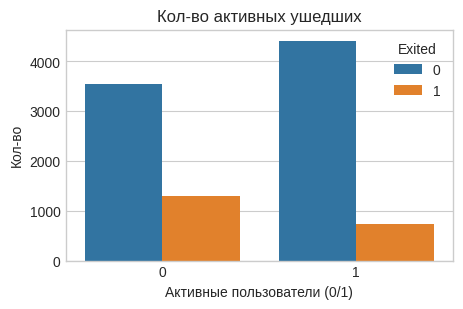

In [26]:
#Исследовательский анализ (EDA) с построением 2-3 гипотез и их визуальной проверкой.
#Гипотеза Неактивные клиенты чаще уходят
plt.figure(figsize=(5,3))
sns.countplot(data=dfb, x='IsActiveMember', hue='Exited')
plt.title('Кол-во активных ушедших')
plt.xlabel('Активные пользователи (0/1)')
plt.ylabel('Кол-во')
plt.show()
# Неактивные клиенты уходят чаще потвержается.
# Нужно поработать с неактивными клиентами, чтобы сохранить их.

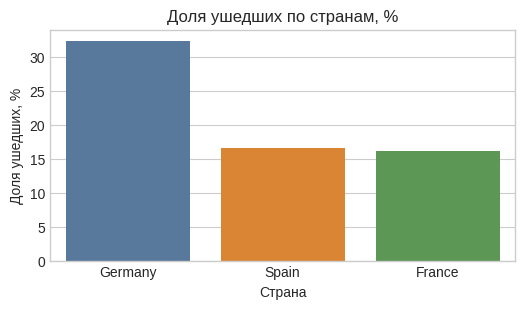

In [27]:
#гипотеза Во Франции доля ушедших больше, чем в Германии и Испании
df_rate2 = (pd.crosstab(dfb['Geography'], dfb['Exited'], normalize='index')[1] * 100).rename('churn_rate').reset_index().sort_values('churn_rate', ascending=False)

palette = {'Germany': '#4C78A8', 'Spain': '#F58518', 'France': '#54A24B'}

plt.figure(figsize=(6,3))
sns.barplot(data=df_rate2,
            x='Geography', y='churn_rate',
            hue='Geography', palette=palette, dodge=False)
plt.title('Доля ушедших по странам, %')
plt.xlabel('Страна')
plt.ylabel('Доля ушедших, %')
plt.show()
# Во Франции доля ушедших больше, чем в Германии и Испании не подтверждается.

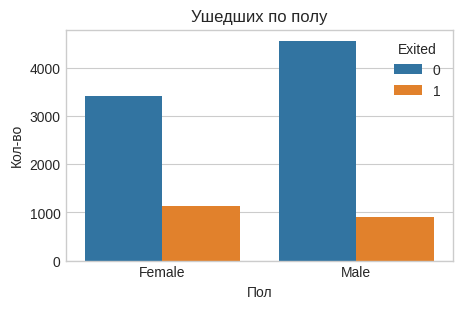

{'Female': 25.1, 'Male': 16.5} p= 0.0


In [28]:
#гипотеза Пол почти не влияет на уход
plt.figure(figsize=(5,3))
sns.countplot(data=dfb, x='Gender', hue='Exited')
plt.title('Ушедших по полу')
plt.xlabel('Пол')
plt.ylabel('Кол-во')
plt.show()

ct = pd.crosstab(dfb['Gender'], dfb['Exited'])
rates = (ct[1] / ct.sum(1) * 100)
from scipy.stats import chi2_contingency
p = chi2_contingency(ct)[1]
print(rates.round(1).to_dict(), 'p=', round(p,4))
# Пол почти не влияет на уход не подтвержается так как p = 0.0 и женщин больше уходит.

In [29]:
#Предобработка данных (обработка пропусков, кодирование категорий, масштабирование).
dfb_ = dfb.drop(columns=['RowNumber','CustomerId','Surname'])

X_full = dfb_.drop(columns='Exited')
y_full = dfb_['Exited'].astype(int)

num_cols = X_full.select_dtypes(include='number').columns
cat_cols = X_full.select_dtypes(exclude='number').columns

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

print('preprocessor готов.')
print('num_cols:', list(num_cols))
print('cat_cols:', list(cat_cols))
# Удалены ID‑поля.
# Числовые признаки масштабируются, категориальные признаки кодируются.

preprocessor готов.
num_cols: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
cat_cols: ['Geography', 'Gender']


In [30]:
#Разделение на обучающую и тестовую выборки.
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full,
    test_size=0.2,
    random_state=42,
    stratify=y_full
)

print('X_train:', X_train.shape, ' X_test:', X_test.shape)
print('y_train:', y_train.mean().round(3), ' y_test:', y_test.mean().round(3))
# Разбиение 80/20

X_train: (8000, 10)  X_test: (2000, 10)
y_train: 0.204  y_test: 0.204


In [31]:
#Построение модели классификации (например, LogisticRegression или RandomForestClassifier).
pipe_lr = Pipeline([
    ('prep', preprocessor),
    ('model', LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42))
]).fit(X_train, y_train)

y_pred = pipe_lr.predict(X_test)

Accuracy: 0.714


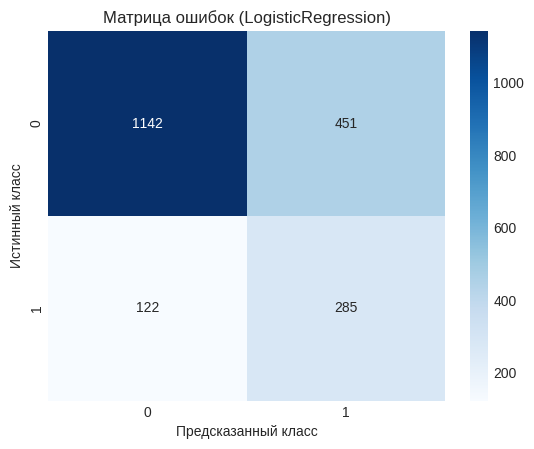

TN=1142  FP=451  FN=122  TP=285


In [32]:
#Оценка модели (accuracy, confusion matrix) и интерпретация результатов с точки зрения бизнеса.
print('Accuracy:', round(accuracy_score(y_test, y_pred), 3))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок (LogisticRegression)')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f'TN={tn}  FP={fp}  FN={fn}  TP={tp}')
# TN = 1142 — верно предсказали что не уйдёт.
# FP = 451 — ошибочно предсказали уход лояльных клиентов (лишние расходы на удержание).
# FN = 122 — не распознали уход (зона упущенных клиентов).
# TP = 285 — верно предсказали уход (можно вовремя предложить меры по удержанию).
# Нужно снижать FN.